In [1]:
import os
from tqdm import tqdm
import numpy as np
os.listdir('../weis/')

['cb']

In [2]:
# Load configuration from environment variables
symbol = os.getenv('SYMBOL')
interval = int(os.getenv('INTERVAL'))
tss_n_splits = int(os.getenv('TSS_N_SPLITS'))
n_back_features = int(os.getenv('N_BACK_FEATURES'))
tss_test_size = int(os.getenv('TSS_TEST_SIZE'))

In [3]:
from predict import ModelPrediction
from datetime import datetime

def get_probas_for_bactesting(end_dt):

    prediction_model = ModelPrediction(
        model_path='../weis/cb',
        verbose=False
    )
    
    return prediction_model.full_prediction_cycle(symbol, interval, n_back_features, tss_n_splits, tss_test_size, end_date=end_dt)

['schedule.py', 'predict.py', 'train.py', 'utils', 'pipeline.py', 'parsing', 'backtest.ipynb', '.ipynb_checkpoints', '__pycache__']


In [23]:
from parsing.hist_parsing import KlineDataRetriever
from utils.utils import preprocess_data
from utils.utils import add_extrema_targets
from time import sleep
import zoneinfo

start_date = datetime(2024, 8, 8, 0, 0, tzinfo=zoneinfo.ZoneInfo('Europe/Moscow'))
end_date = datetime.now(zoneinfo.ZoneInfo('Europe/Moscow'))#datetime(2024, 7, 22, tzinfo=zoneinfo.ZoneInfo('Europe/Moscow'))

retriever = KlineDataRetriever('linear', symbol, interval, testnet=False)

backtest_data = retriever.fetch_data(start_date=start_date, end_date=end_date)

backtest_data = preprocess_data(backtest_data)
backtest_data = add_extrema_targets(backtest_data)

print(len(backtest_data))

3800


In [24]:
preds = []


for dt in tqdm(backtest_data['DATETIME'].tolist()):
    bhs = get_probas_for_bactesting(dt)
    
    preds.append(bhs)
    
    sleep(0.01)
    
preds[:10]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3800/3800 [31:20<00:00,  2.02it/s]


[(0.0008021502748340343, 0.1685162401857911, 0.8306816095393749),
 (0.00014552453457921034, 0.12411218939022911, 0.8757422860751917),
 (0.00031332502872053326, 0.31087530366085925, 0.6888113713104203),
 (0.023558502509855396, 0.9538290511532908, 0.02261244633685397),
 (0.25572563541393345, 0.7384344154501922, 0.005839949135874366),
 (0.13701871049818926, 0.8419009406391695, 0.021080348862641245),
 (0.013533627130801997, 0.5455863211406035, 0.44088005172859457),
 (0.8037204220202436, 0.19533796485139937, 0.0009416131283569338),
 (0.20687352509952925, 0.7840382233535078, 0.009088251546962942),
 (0.7524808249501035, 0.24688138405724408, 0.0006377909926524767)]

In [41]:
buy_probas = [x[0] for x in preds]
sell_probas = [x[2] for x in preds]
hold_probas = [x[1] for x in preds]

ts = [0.53, 0, 0.53]

def make_decision(x, ts): 
    b, h, s = x
    if b > ts[0]:
        return 0
    elif s > ts[2]:
        return 2
    else:
        return 1

decisions = [make_decision(x, ts) for x in preds]

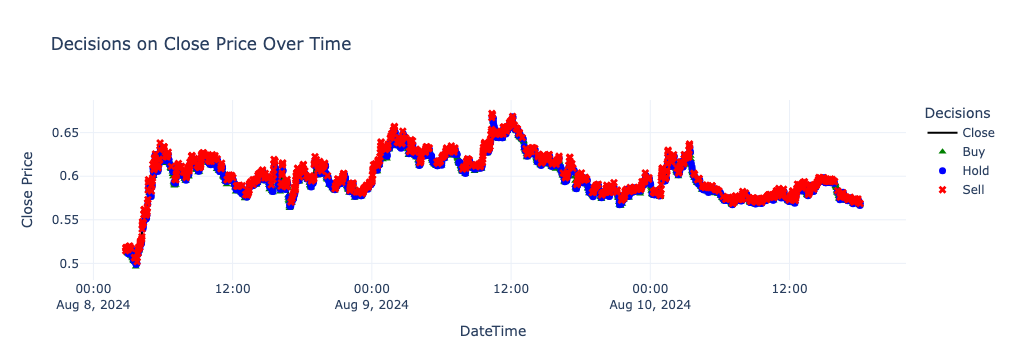

In [42]:
import plotly.graph_objs as go
import pandas as pd

def plot_decisions_with_markers(decisions, datetimes, closes):
    # Create a DataFrame from the provided lists
    df = pd.DataFrame({
        'DateTime': pd.to_datetime(datetimes),
        'Close': closes,
        'Decision': decisions
    })
    
    # Map decisions to colors, labels, and symbols
    decision_colors = {0: 'green', 1: 'blue', 2: 'red'}
    decision_labels = {0: 'Buy', 1: 'Hold', 2: 'Sell'}
    decision_symbols = {0: 'triangle-up', 1: 'circle', 2: 'x'}
    
    # Create the base plot
    fig = go.Figure()
    
    # Add the Close price line
    fig.add_trace(go.Scatter(x=df['DateTime'], y=df['Close'], mode='lines', name='Close', line=dict(color='black')))
    
    # Add decision markers with different shapes and colors
    for decision in decision_colors.keys():
        decision_df = df[df['Decision'] == decision]
        fig.add_trace(go.Scatter(
            x=decision_df['DateTime'],
            y=decision_df['Close'],
            mode='markers',
            name=decision_labels[decision],
            marker=dict(color=decision_colors[decision], size=7, symbol=decision_symbols[decision])
        ))
    
    # Update layout for better visualization
    fig.update_layout(
        title='Decisions on Close Price Over Time',
        xaxis_title='DateTime',
        yaxis_title='Close Price',
        legend_title='Decisions',
        template='plotly_white'
    )
    
    fig.show()
    
plot_decisions_with_markers(datetimes=backtest_data['DATETIME'], closes=backtest_data['CLOSE'], decisions=decisions)

In [43]:
def backtest_strategy(decisions, initial_balance=10000, price_data=None, taker_fee=0.0018, maker_fee=0.0010):
    balance = initial_balance
    position = 0  # Current position: +1 for holding, 0 for no position
    transaction_log = []  # To keep track of all transactions

    for i, decision in enumerate(decisions):
        price = price_data[i] if price_data is not None else 100  # Assume a default price if not provided
        if decision == 0:  # Buy
            if position == 0:  # Only buy if not holding
                position = (balance / price) * (1 - taker_fee)  # Buy as much as possible minus fees
                balance = 0  # Spend all balance
                transaction_log.append(f"Buy at {price} with {taker_fee*100}% fee")
        elif decision == 2:  # Sell
            if position > 0:  # Only sell if holding
                balance = position * price * (1 - taker_fee)  # Sell all holdings minus fees
                position = 0  # Clear position
                transaction_log.append(f"Sell at {price} with {taker_fee*100}% fee")
        # No action needed for hold (1)

    # If still holding at the end, sell at the last price
    if position > 0:
        balance = position * price * (1 - taker_fee)  # Sell all at the last known price minus fees
        transaction_log.append(f"Final sell at {price} with {taker_fee*100}% fee")

    final_balance = balance
    roi = (final_balance - initial_balance) / initial_balance * 100

    # Print out the results
    #print("Transaction Log:")
    #for log in transaction_log:
        #print(log)
    #print(f"Final Balance: ${final_balance:.2f}")
    #print(f"ROI: {roi:.2f}%")
    return final_balance, roi


initial_balance = 100

# Run the backtest
final_balance, roi = backtest_strategy(decisions, initial_balance, backtest_data['CLOSE'])

print(roi)

29.935489772370943


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:31<00:00, 319.51it/s]


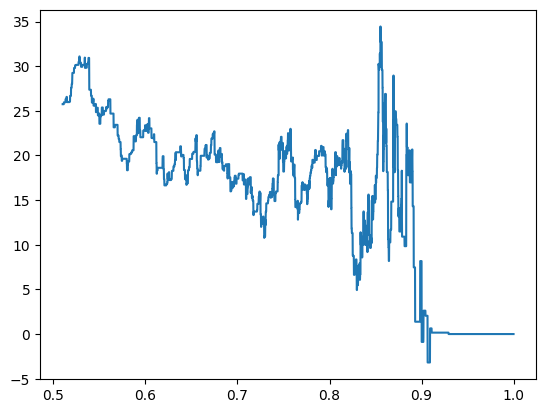

In [34]:
# Grid Search

all_tss, all_rois = [], []

for thresh in tqdm(np.linspace(0.51, 1.0, 10000)):
    tss = [thresh, 0, thresh]

    gs_decisions = [make_decision(x, tss) for x in preds]

    final_balance, roi = backtest_strategy(gs_decisions, initial_balance, backtest_data['CLOSE'])

    all_tss.append(thresh)
    all_rois.append(roi)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_tss, all_rois)
plt.show()
    